<a href="https://colab.research.google.com/github/mcbe/mmci/blob/master/block2_mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Exercise 2: Classification with MNIST

*Applied Data Science; June 13, 2020*

**Please note that this exercise may be completed in groups.**

**Due:** *Friday, June 26 at 11:59pm*

---
In this exercise, we'll explore classification of handwritten digits from the MNIST dataset.

Goals are as follows:

- Train a logistic regression model to classify handwritten digits
- Visualize the filters for each digit learned by logistic regression
- Train a simple MLP to classify handwritten digits, and understand why it is more effective than logistic regression
- Visualize the filters learned by the MLP
- Observe that logistic regression is *not* effective when digits are not centered (why?)
- Train a simple CNN to identify digits *even when their position varies*
- Visualize the filters for each digit learned by the CNN
- *Extra Credit*: Create and train a model that classifies handwritten digits with over 98% accuracy

We'll begin by importing required libraries:

- numpy for efficient math operations
- sklearn for defining and training our logistic regression and MLP models
- tensorflow for defining and training our simple CNN
- matplotlib for visualization/plotting

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

Next, we'll load the MNIST dataset. The data are already broken down into:

1. a development set, which we'll use for training
2. a test set, which we'll use to evaluate performance

Since we will not be tuning our models, we will not set aside a validation set. If we were going to create a validation set, we would divide `y_dev` into `y_train` and `y_val`, then evaluate on the test set only once, after deciding on a model. This would give us a more realistic estimate of model performance. Instead, our primary goal here is to understand what is happening with each model.

In [2]:
# Load MNIST
(x_dev, y_dev), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print('There are', len(x_dev), 'training images.')
print('There are', len(x_test), 'test images.')

11493376/11490434 [==============================] - 0s 0us/step
There are 60000 training images.
There are 10000 test images.


Let's look at 10 example images from our training set. The code block below uses the `ax.imshow` method from matplotlib, which we will also use later in the exercise to visualize learned filters.

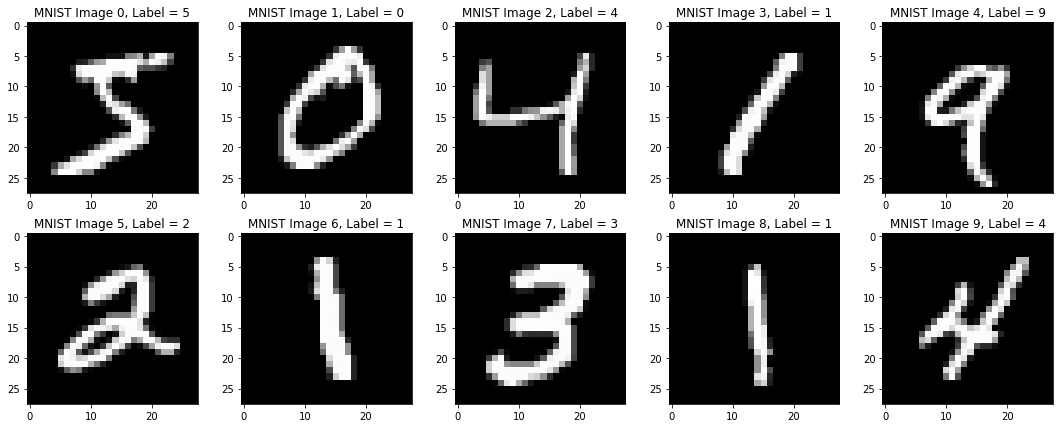

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i in range(10):
    ax[i // 5, i % 5].imshow(x_dev[i, :, :], cmap='gray')
    ax[i // 5, i % 5].set_title('MNIST Image %i, Label = %i' % (i, y_dev[i]), fontsize=12)
plt.tight_layout()
plt.show()

From the plots above, we can see that there are 3 ones in the first 10 training images. Let's look at the distribution of the labels across the whole training set to make sure that all 10 digits are equally represented, more or less. In this block, we'll use `np.unique()` to count the number of times each digit occurs within `y_dev`, the labels for our training data.

In generating our plot, the important command is `plt.bar(y_dev_values, y_dev_counts)`, which plots a bar graph of the counts for each value of the labels. The remaining commands make the plot a little more readable.

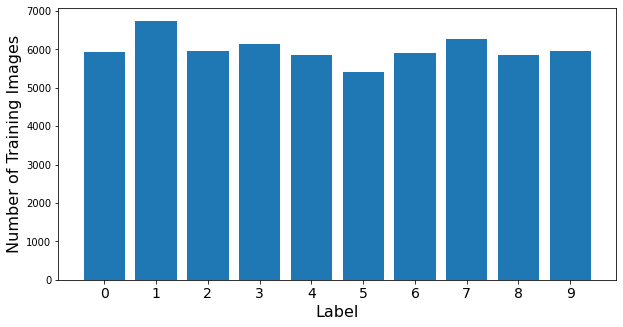

In [6]:
y_dev_values, y_dev_counts = np.unique(y_dev, return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(y_dev_values, y_dev_counts)
plt.xticks(np.arange(10), fontsize=14)
plt.ylabel('Number of Training Images', fontsize=16)
plt.xlabel('Label', fontsize=16)
plt.show()

## Logistic Regression

It looks like all digits are represented equally, more or less. Let's train a logistic regression model to classify them. As in the previous exercise, we'll use `LogisticRegression` from `sklearn.linear_model`.

In [7]:
lr = LogisticRegression(max_iter=10)
lr.fit(x_dev.reshape(-1, 28 * 28), y_dev)
y_test_pred = lr.predict(x_test.reshape(-1, 28 * 28))
print('Test Accuracy: %.2f%%' % (100 * sum(y_test_pred == y_test) / len(y_test)))

Test Accuracy: 88.88%


If we were to guess the labels at random we'd be right only 10% of the time, so ~89% accuracy is pretty good.

### Visualize the learned filters

In the block below, we *un*-vectorize the logistic regression weights (with `filt.reshape(28, 28)`) so they have the same shape as the MNIST images. This allows them to be viewed and interpreted as filters, as we have discussed in class.

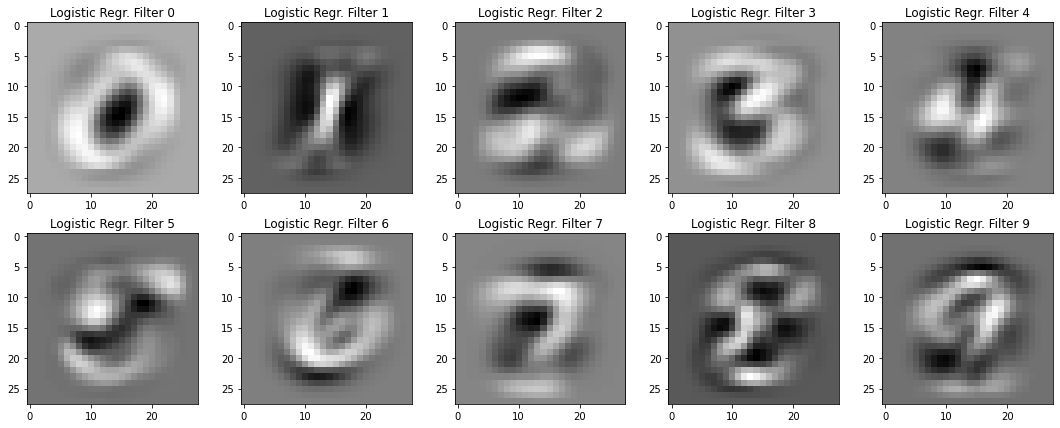

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i, filt in enumerate(lr.coef_):
    ax[i // 5, i % 5].imshow(filt.reshape(28, 28), cmap='gray')
    ax[i // 5, i % 5].set_title('Logistic Regr. Filter %i' % i, fontsize=12)
plt.tight_layout()
plt.show()

### Question 1: describe the learned filters

In a few sentences, describe (a) why these filters look somewhat like the digits they are designed to detect; and (b) why they don't look *exactly* like digits (i.e., why are they blurry)?

## Multilayer Perceptron

Next, we'll train multilayer perceptron (1 hidden layer; 50 hidden units) using `MLPClassifier` from `sklearn.neural_network`.

In [0]:
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=20, alpha=10)
mlp.fit(x_dev.reshape(-1, 28 * 28), y_dev)
y_test_pred = mlp.predict(x_test.reshape(-1, 28 * 28))
print('Test Accuracy: %.2f%%' % (100 * sum(y_test_pred == y_test) / len(y_test)))

Accuracy: 96.23%


### Question 2: MLP performance

In a few sentences, describe some advantages of the MLP that may explain why it is able to exceed the performance of our previous, logistic regression model.

### Visualize the learned filters

As before, we *un*-vectorize the MLP weights (in the first layer) so they may be interpreted as filters applied to the MNIST images.

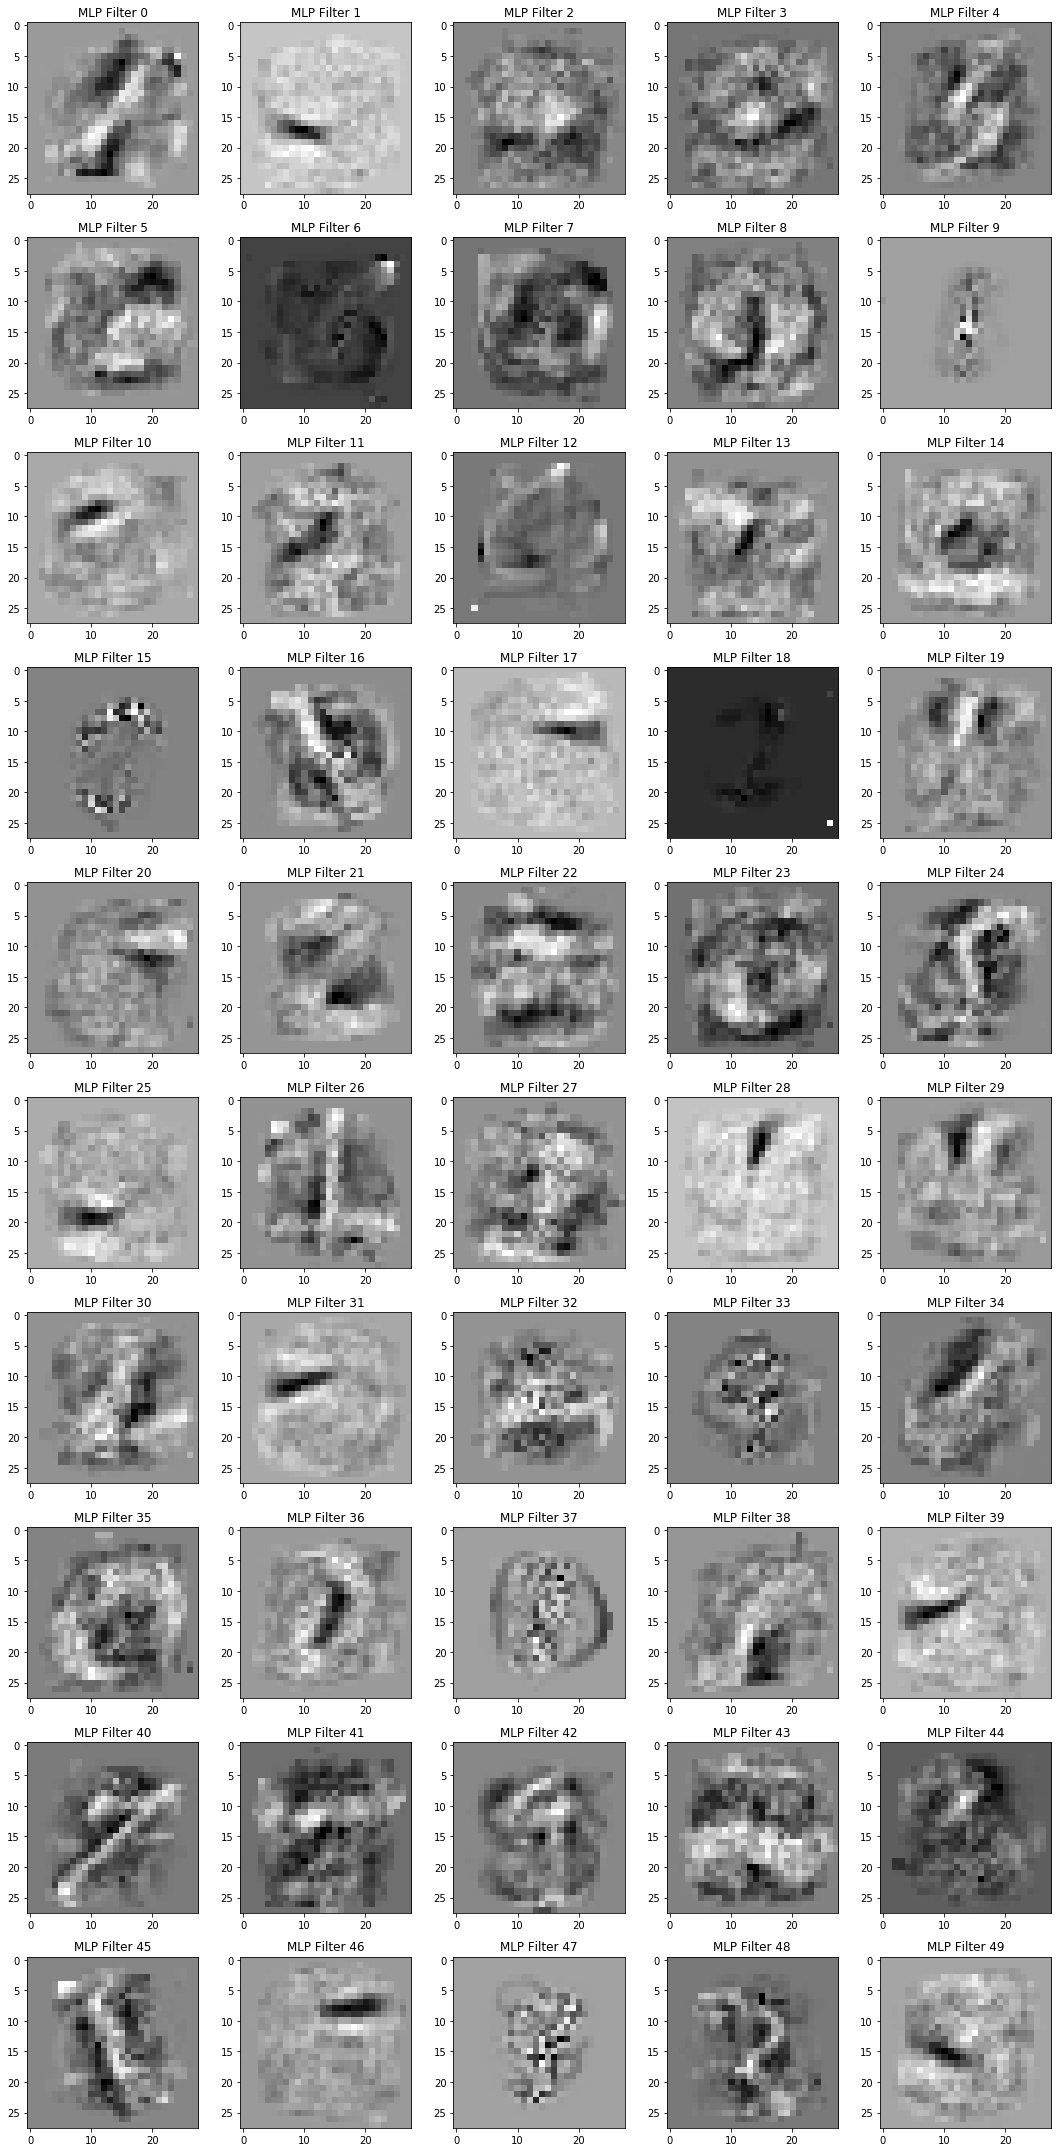

In [0]:
fig, ax = plt.subplots(nrows=10, ncols=5, figsize=(15, 30))
for i, filt in enumerate(mlp.coefs_[0].T):
    ax[i // 5, i % 5].imshow(filt.reshape(28, 28), cmap='gray')
    ax[i // 5, i % 5].set_title('MLP Filter %i' % i, fontsize=12)
plt.tight_layout()
plt.show()

In class, we suggested that having additional filters might allow the MLP to identify different ways/styles of writing each digit. Do the filters above seem to be identifying different handwriting styles? If not, what else might they identifying? *(This is not a required question)*

## Convolutional Neural Network
The CNN is designed to detect features *regardless of their position within an image*. Let's explore this idea. We'll begin by modifying the MNIST dataset to (a) enlarge the images, and (b) place digits at random positions within the enlarged image. We'll do this by padding each image (in both our development and test sets) with zeroes.

In [0]:
def pad_image(img, pad_len):
    m, n = img.shape
    i = np.random.randint(pad_len - 2) + 1
    j = np.random.randint(pad_len - 2) + 1
    img = np.concatenate([[[0] * i] * m, img, [[0] * (pad_len - i)] * m], axis=1)
    return np.concatenate([[[0] * (n + pad_len)] * j, img, [[0] * (n + pad_len)] * (pad_len - j)], axis=0)

x_dev_padded = np.array([pad_image(x, 20) for x in x_dev])
x_test_padded = np.array([pad_image(x, 20) for x in x_test])

In the plots below, we see that digits are no longer centered in the modified dataset.

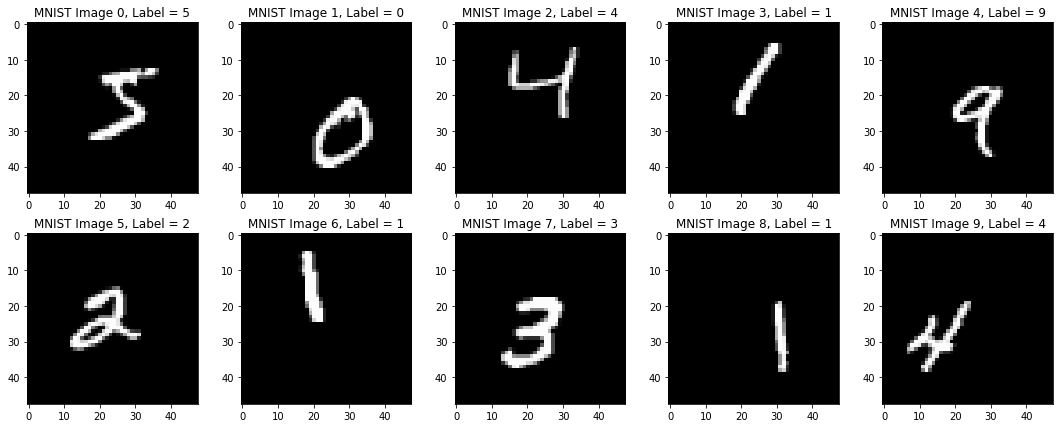

In [0]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i in range(10):
    ax[i // 5, i % 5].imshow(x_dev_padded[i, :, :], cmap='gray')
    ax[i // 5, i % 5].set_title('MNIST Image %i, Label = %i' % (i, y_dev[i]), fontsize=12)
plt.tight_layout()
plt.show()

Let's see whether logistic regression is able to classify digits effectively now that they're not centered.

In [0]:
lr = LogisticRegression(max_iter=10)
lr.fit(x_dev_padded.reshape(-1, 48 * 48), y_dev)
y_test_pred = lr.predict(x_test_padded.reshape(-1, 48 * 48))
print('Test Accuracy: %.2f%%' % (100 * sum(y_test_pred == y_test) / len(y_test)))

Accuracy: 23.57%


As we hypothesized, performance is poor. It's worth noting, however, that performance is still better than random. What features of these images is the logistic regression model identifying? Let's take a look...

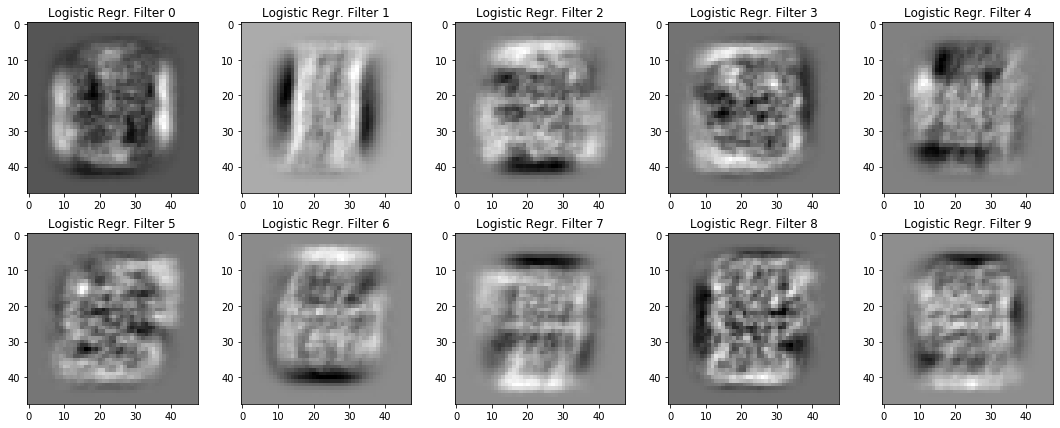

In [0]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i, filt in enumerate(lr.coef_):
    ax[i // 5, i % 5].imshow(filt.reshape(48, 48), cmap='gray')
    ax[i // 5, i % 5].set_title('Logistic Regr. Filter %i' % i, fontsize=12)
plt.tight_layout()
plt.show()

How would you describe the appearance of these filters, and why might they appear this way? *(This is not a required question)*

Let's see if a CNN can do better. In the code below, we'll define and train a very simple CNN that follows the example from class. Specifically, we'll use 10 filters, one for each digit, each of size 28 x 28 -- the same size as the unmodified MNIST images. We'll max pool the output of each filter across the whole image, which should tell us whether the digit corresponding to that filter is present *anywhere* within the image. The output of the pooling operations will give us the predicted log-odds for each of the 10 digits.

**Notes**:
- This is an unusual CNN. Typically we use much smaller filters -- and a larger number of them -- but here we are using large filters to illustrate the connection to our previous models.
- You do not need to understand the code in the following blocks. This code is required to define and train our custom CNN architecture.

In [0]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Model

x_dev_cnn = x_dev_padded.astype('float32')[..., tf.newaxis]
x_test_cnn = x_test_padded.astype('float32')[..., tf.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices((x_dev_cnn, y_dev)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_cnn, y_test)).batch(32)
    
class SimpleCNN(Model):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = Conv2D(10, 28, use_bias=False)
        self.mp1 = MaxPool2D(21)
        self.flatten = Flatten()

    def call(self, x):
        x = self.conv1(x)
        x = self.mp1(x)
        return self.flatten(x)

model = SimpleCNN()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

The code above defines our model, and the functions below are used to train the model and make predictions, respectively. The details of these blocks are not central to our goal, which is to understand, intuitively, what the model is doing. However, these details may be interesting to those who would like to create their own models.

In [0]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

We're now ready to train.

In [0]:
EPOCHS = 3

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
        
    print('Epoch %i, Loss: %.3f, Accuracy: %.2f%%, Test Loss: %.3f, Test Accuracy: %.2f%%' % (
        (epoch + 1),
        train_loss.result(),
        train_accuracy.result() * 100,
        test_loss.result(),
        test_accuracy.result() * 100))

Epoch 1, Loss: 3.618, Accuracy: 86.12%, Test Loss: 2.830, Test Accuracy: 91.25%
Epoch 2, Loss: 3.338, Accuracy: 91.33%, Test Loss: 3.574, Test Accuracy: 91.48%
Epoch 3, Loss: 3.467, Accuracy: 92.39%, Test Loss: 2.864, Test Accuracy: 94.04%


As we hypothesized, our CNN is able to recognize these digits effectively even though they're no longer centered, with a test accuracy of over 94%. Let's take a look at the filters corresponding to each digit.

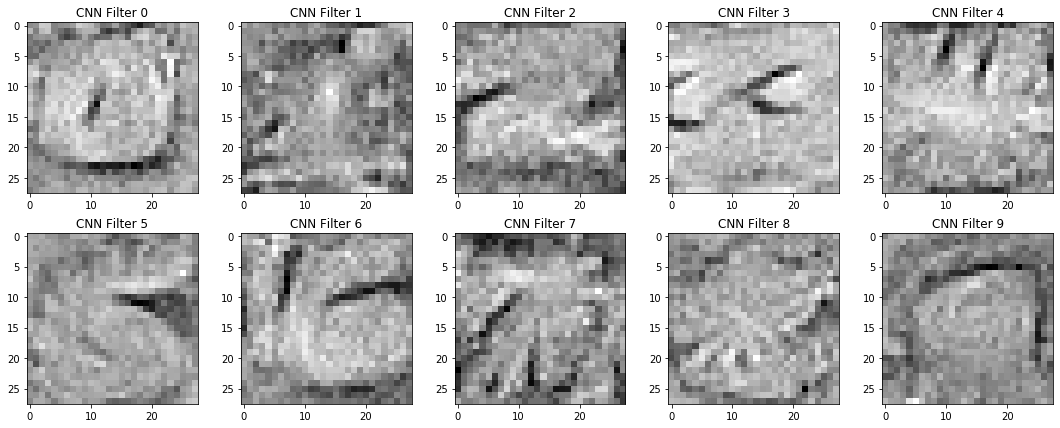

In [0]:
filters = model.conv1.get_weights()[0]

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i in range(10):
    ax[i // 5, i % 5].imshow(filters[:, :, 0, i], cmap='gray')
    ax[i // 5, i % 5].set_title('CNN Filter %i' % i, fontsize=12)
plt.tight_layout()
plt.show()

Do these filters resemble the digits they identify? If not, why might these be the case? *(This is not a required question)*

### Question 3: Rotated Digits
We've now demonstrated that a CNN can identify digits even when they're not centered. Would our trained CNN be able to correctly identify digits even if they were rotated? For example, we might modify the test set so that all images were rotated by 90 degrees, then try to predict their labels using the model we have already trained. In a few sentences, describe why this would work, or why not. It may be interesting to test your hypothesis, but this is not required.

### Question 4: Beyond MNIST
Classifying handwritten digits is a difficult problem, but classification of medical images tends to be much more difficult. In 2-3 short paragraphs, describe a potential clinical/medical application of CNN-based image classification that is different from those discussed in class. What are some obstacles you might expect to encounter when designing or implementing a model for this application? These obstacles could be technical, clinical, or both.

### Extra Credit Challenge:
Create and train a model (on the development set) that is over 98% accurate on the test set. You may use an MLP, a CNN, or any other model you like.